In [18]:
!pip uninstall numpy -y
!pip install numpy==1.26.4
!pip uninstall scikit-surprise -y
!pip install scikit-surprise

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.92 requires numpy>=2; python_version >=

Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
movies = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ml-latest-small/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ml-latest-small/ratings.csv")

print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Unique users:", ratings['userId'].nunique())
print("Unique movies:", ratings['movieId'].nunique())

Movies shape: (9742, 3)
Ratings shape: (100836, 4)
Unique users: 610
Unique movies: 9724


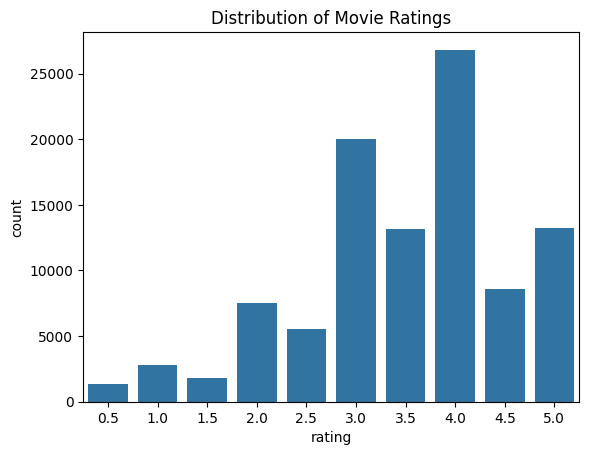

In [22]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of Movie Ratings")
plt.show()

In [23]:
movies['genres'] = movies['genres'].replace("(no genres listed)", "")

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies.index, index=movies['title'])

In [24]:
data = pd.merge(ratings, movies, on="movieId")

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [25]:
def get_similar_movies(movie_id, top_n=5):
    if movie_id not in movies['movieId'].values:
        return []

    idx = movies[movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices]['movieId'].values

In [26]:
from collections import defaultdict

def content_precision_recall(test_data, k=5, threshold=3.5):

    user_true_movies = defaultdict(set)
    user_recommended = defaultdict(set)

    for _, row in test_data.iterrows():
        if row['rating'] >= threshold:
            user_true_movies[row['userId']].add(row['movieId'])

    for user in test_data['userId'].unique():
        user_movies = train_data[train_data['userId'] == user]['movieId'].values

        recommended_movies = []
        for movie in user_movies:
            similar = get_similar_movies(movie, top_n=k)
            recommended_movies.extend(similar)

        user_recommended[user] = set(recommended_movies[:k])

    precisions = []
    recalls = []

    for user in user_true_movies:
        true = user_true_movies[user]
        recommended = user_recommended[user]

        if len(recommended) == 0:
            continue

        intersection = true.intersection(recommended)

        precision = len(intersection) / len(recommended)
        recall = len(intersection) / len(true) if len(true) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

In [17]:
prec_content, rec_content = content_precision_recall(test_data)

print("Content-Based Precision:", prec_content)
print("Content-Based Recall:", rec_content)

Content-Based Precision: 0.009650582362728786
Content-Based Recall: 0.003932453197257899


In [27]:
def content_recommend(movie_title, n=5):
    idx = indices[movie_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

content_recommend("Toy Story (1995)")

,title
1706,Antz (1998)
2355,Toy Story 2 (1999)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"


In [28]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = surprise_split(data, test_size=0.2)

In [29]:
sim_options = {
    "name": "cosine",
    "user_based": True
}

knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(trainset)

predictions_knn = knn_model.test(testset)

print("User-Based CF Results:")
accuracy.rmse(predictions_knn)
accuracy.mae(predictions_knn)

Computing the cosine similarity matrix...
Done computing similarity matrix.
User-Based CF Results:
RMSE: 0.9748
MAE:  0.7496


0.7495570670241174

In [30]:
svd_model = SVD()
svd_model.fit(trainset)

predictions_svd = svd_model.test(testset)

print("SVD Results:")
accuracy.rmse(predictions_svd)
accuracy.mae(predictions_svd)

SVD Results:
RMSE: 0.8746
MAE:  0.6719


0.6719310882788626

In [31]:
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

print("Best RMSE Score:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE Score: 0.8737456079624745
Best Parameters: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1}


In [32]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

In [33]:
prec_knn, rec_knn = precision_recall_at_k(predictions_knn)
prec_svd, rec_svd = precision_recall_at_k(predictions_svd)

print("KNN Precision:", prec_knn)
print("KNN Recall:", rec_knn)

print("SVD Precision:", prec_svd)
print("SVD Recall:", rec_svd)

KNN Precision: 0.7774220032840723
KNN Recall: 0.41259912807120613
SVD Precision: 0.7735084838533115
SVD Recall: 0.391631762610096


In [34]:
results = pd.DataFrame({
    "Model": ["Content-Based",
              "User-Based CF (KNN)",
              "Matrix Factorization (SVD)"],

    "RMSE": [np.nan,
             accuracy.rmse(predictions_knn, verbose=False),
             accuracy.rmse(predictions_svd, verbose=False)],

    "MAE": [np.nan,
            accuracy.mae(predictions_knn, verbose=False),
            accuracy.mae(predictions_svd, verbose=False)],

    "Precision@5": [prec_content,
                    prec_knn,
                    prec_svd],

    "Recall@5": [rec_content,
                 rec_knn,
                 rec_svd]
})

results

,Model,RMSE,MAE,Precision@5,Recall@5
0,Content-Based,NaN,NaN,0.009651,0.003932
1,User-Based CF (KNN),0.974817,0.749557,0.777422,0.412599
2,Matrix Factorization (SVD),0.874632,0.671931,0.773508,0.391632
